In [550]:
import pandas as pd
import os
import catomatic
import matplotlib.pyplot as plt
import seaborn as sns
from upsetplot import UpSet
from upsetplot import from_indicators



# Notebook to generate training and validation sets

In [551]:
cryptic = pd.read_csv("../data/CRyPTIC_reuse_table_20231208.csv")
mykrobe = pd.read_csv("./mykrobe.20231121.tsv", sep='\t')
validation = pd.read_csv( "./validation_set_20231110.pass.tsv", sep='\t')

There are 3 datasets at the moment:
- Cryptic
- Mykrobe
- Validation 

CRyPTIC and mykrobe datasets will be combined to form the training set.

In [552]:
# Find common IDs between CRyPTIC and mykrobe
training_ids_in_common = set(mykrobe['sample']).intersection(cryptic['ENA_SAMPLE'])
print ('number of shared samples between cryptic and mykrobe:', len(training_ids_in_common))

# Find common IDs between mykrobe and validation set
validation_ids_in_common = set(mykrobe['sample']).intersection(validation['sample'])
print ('number of shared samples between mykrobe and validation set:', len(validation_ids_in_common))


number of shared samples between cryptic and mykrobe: 501
number of shared samples between mykrobe and validation set: 131


These are all site 6 (Italy) samples.

In [553]:

# Define the drug-to-code dictionary directly
drug_translation = {
    "amikacin": "AMI", "bedaquiline": "BDQ", "capreomycin": "CAP", "ciprofloxacin": "CIP",
    "clofazimine": "CFZ", "cycloserine": "CS", "delamanid": "DLM", "ethambutol": "EMB",
    "ethionamide": "ETH", "isoniazid": "INH", "kanamycin": "KAN", "levofloxacin": "LEV",
    "linezolid": "LZD", "moxifloxacin": "MXF", "ofloxacin": "OXF", "pas": "PAS",
    "pyrazinamide": "PZA", "rifabutin": "RFB", "rifampicin": "RIF", "streptomycin": "STR"
}

drug_phenotype_quality = [f"{drug}_phenotype_quality" for drug in drug_translation]
colnames_order = ["ena_run", "ena_sample", "ena_project", "dataset"] + list(drug_translation) + drug_phenotype_quality

#samples to filter out from mykrobe (either shared in cryptic or validation set)
samples_to_filter = training_ids_in_common.union(validation_ids_in_common)

# Process mykrobe data
mykrobe= (
    mykrobe
    .rename(columns={'run': 'ena_run', 'sample': 'ena_sample', 'project': 'ena_project'})
    .assign(**{drug: "U" for drug in set(drug_translation) - set(mykrobe.columns[3:19])})  # Add missing drugs with U phenotypes
    .assign(**{quality: "MEDIUM" for quality in drug_phenotype_quality})  # Add  MEDIUM phenotype quality
    .assign(dataset="mykrobe")  # Add dataset column
    .loc[~mykrobe['sample'].isin(samples_to_filter), colnames_order]  # Filter out shared samples between cryptic and mykrobe!!
)


In [554]:
reverse_translation = {v: k for k, v in drug_translation.items()}

cryptic = (
    cryptic
    .filter(regex="TYPE$|ENA_RUN|ENA_SAMPLE|QUALITY$")  # Select relevant columns
    .rename(columns=lambda x: x.replace("_BINARY_PHENOTYPE", ""))  # Remove "_BINARY_PHENOTYPE"
    .assign(ena_project="-")  # Add 'ena_project' column
    .rename(columns={"ENA_RUN": "ena_run", "ENA_SAMPLE": "ena_sample"})  # Rename columns
)

cryptic_drug_codes = cryptic.columns.tolist()
cryptic_drugs = [drug for drug, code in drug_translation.items() if code in cryptic_drug_codes]

# Identify missing drugs and qualities
missing_drugs = set(drug_translation.keys()) - set(cryptic_drugs)
missing_qualities = set(drug_phenotype_quality) - {f"{drug}_phenotype_quality" for drug in cryptic_drugs}

# Add missing drugs and qualities with default values
for col in missing_drugs:
    cryptic[col] = "U"
for col in missing_qualities:
    cryptic[col] = "U"

# Function to rename columns based on the dictionaries
def rename_column(col):
    for code, drug in reverse_translation.items():
        if code in col:  # Replace code with full name
            return col.replace(code, drug)
    return col  # Keep as-is if no match

# Apply the renaming function to the columns
cryptic.columns = [rename_column(col) for col in cryptic.columns]
cryptic.columns = cryptic.columns.str.lower()

# Add dataset column and reorder columns
cryptic = cryptic.assign(dataset="CRyPTIC_I").reindex(columns=colnames_order, fill_value="U")

NaN phenotypes are being filled with Us - need to think about this. Don't think its the right thing to do, will circle back.

The horizontal format of the tables doesn't work well - its forcing me to add in columns (ie drugs) that arent shared - would make far more sense to use the cryptic format.

In [555]:
# Combine training data
training_data = pd.concat([cryptic, mykrobe], axis=0)
# Save training and validation exclusion data
training_data.to_csv(f"./training_data_20250117.csv", index=False)
training_data

,ena_run,ena_sample,ena_project,dataset,amikacin,bedaquiline,capreomycin,ciprofloxacin,clofazimine,cycloserine,...,kanamycin_phenotype_quality,levofloxacin_phenotype_quality,linezolid_phenotype_quality,moxifloxacin_phenotype_quality,ofloxacin_phenotype_quality,pas_phenotype_quality,pyrazinamide_phenotype_quality,rifabutin_phenotype_quality,rifampicin_phenotype_quality,streptomycin_phenotype_quality
0,ERR4810489,ERS5298516,-,CRyPTIC_I,S,NaN,U,U,S,U,...,HIGH,HIGH,HIGH,HIGH,U,U,U,HIGH,HIGH,U
1,ERR4810491,ERS5298518,-,CRyPTIC_I,S,S,U,U,S,U,...,HIGH,HIGH,HIGH,LOW,U,U,U,HIGH,HIGH,U
2,ERR4810493,ERS5298520,-,CRyPTIC_I,S,S,U,U,S,U,...,HIGH,HIGH,HIGH,HIGH,U,U,U,HIGH,HIGH,U
3,ERR4810494,ERS5298521,-,CRyPTIC_I,S,S,U,U,S,U,...,HIGH,HIGH,HIGH,HIGH,U,U,U,HIGH,HIGH,U
4,ERR4810495,ERS5298522,-,CRyPTIC_I,S,S,U,U,S,U,...,HIGH,HIGH,HIGH,HIGH,U,U,U,HIGH,HIGH,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13373,SRR6046900,SRS2520008,SRP117784,mykrobe,U,U,U,U,U,U,...,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM
13374,SRR6046901,SRS2521668,SRP117784,mykrobe,U,U,U,S,U,U,...,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM
13375,SRR6046902,SRS2521672,SRP117784,mykrobe,U,U,U,U,U,U,...,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM
13376,SRR6046905,SRS2521666,SRP117784,mykrobe,U,U,U,U,U,U,...,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM,MEDIUM


In [556]:
training_data_long = training_data.melt(
    id_vars=['ena_run', 'ena_sample', 'ena_project', 'dataset'],
    var_name='column',
    value_name='value'
)

# Split the 'column' into 'drug' and either 'phenotype' or 'phenotype_quality'
training_data_long['drug'] = training_data_long['column'].str.replace('_phenotype_quality', '', regex=False)
training_data_long['type'] = training_data_long['column'].apply(
    lambda x: 'phenotype_quality' if 'phenotype_quality' in x else 'phenotype'
)

# Pivot to separate phenotype and quality columns
training_data_long = training_data_long.pivot(
    index=['ena_run', 'ena_sample', 'ena_project', 'dataset', 'drug'],
    columns='type',
    values='value'
).reset_index()

training_data_long.to_csv(f"./training_data_long_format_20250117.csv", index=False)


In [557]:
# Replace empty strings with 'U' and add constant columns
validation.iloc[:, 4:] = validation.iloc[:, 4:].replace("", "U")
validation['dataset'] = "validation"
validation.rename(columns={
    'run': 'ena_run',
    'sample': 'ena_sample',
    'project': 'ena_project',
    'para-aminosalicylic_acid': 'pas'
}, inplace=True)
validation['ethionamide'] = "U"  # Add 'ethionamide' column

# Pivot the data directly
validation_long = validation.melt(
    id_vars=['ena_run', 'ena_sample', 'ena_project', 'dataset'],
    var_name='drug',
    value_name='phenotype'
)

# Add quality information by pivoting and merging
validation_long['phenotype_quality'] = validation_long['phenotype'].map(
    lambda x: "U" if x == "U" else "Unknown"
)
validation_long.to_csv(f"./validation_data_long_format_20250117.csv", index=False)


In [558]:
validation_long

,ena_run,ena_sample,ena_project,dataset,drug,phenotype,phenotype_quality
0,ERR036186,ERS019735,PRJEB2358,validation,amikacin,NaN,Unknown
1,ERR036187,ERS019744,PRJEB2358,validation,amikacin,NaN,Unknown
2,ERR036188,ERS019745,PRJEB2358,validation,amikacin,NaN,Unknown
3,ERR036189,ERS019746,PRJEB2358,validation,amikacin,NaN,Unknown
4,ERR036190,ERS019736,PRJEB2358,validation,amikacin,NaN,Unknown
...,...,...,...,...,...,...,...
196103,SRR9851584,SRS5170828,PRJNA557083,validation,thioacetazone,NaN,Unknown
196104,SRR9851585,SRS5170827,PRJNA557083,validation,thioacetazone,NaN,Unknown
196105,SRR9851586,SRS5170826,PRJNA557083,validation,thioacetazone,NaN,Unknown
196106,SRR9851587,SRS5170825,PRJNA557083,validation,thioacetazone,NaN,Unknown


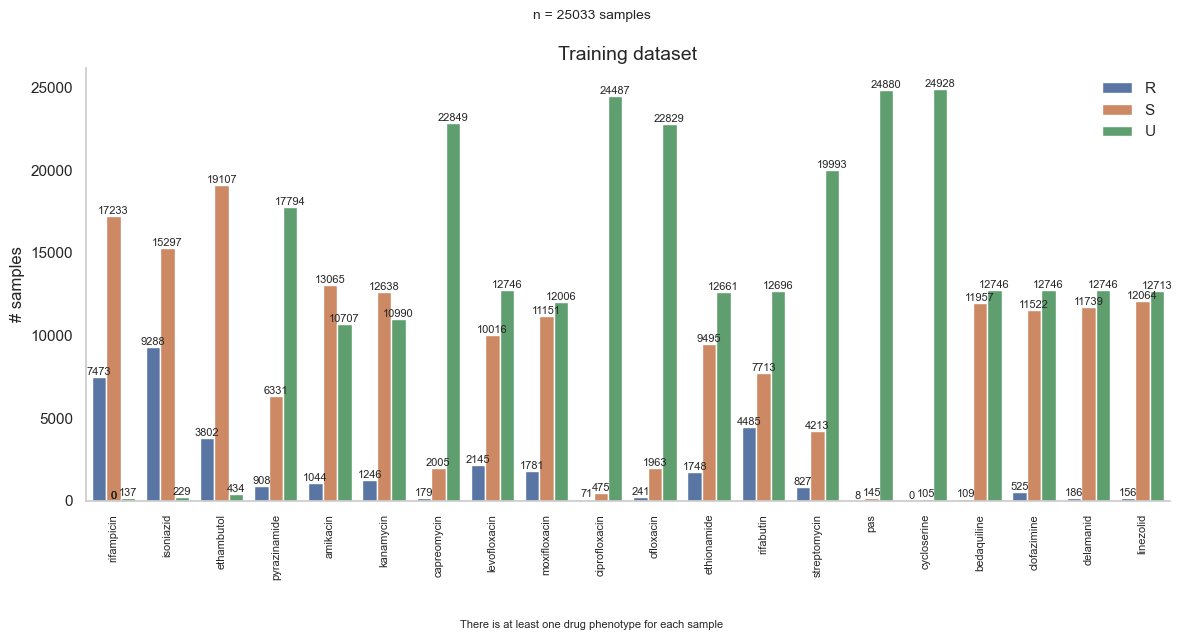

In [563]:
# Number of samples
n_samples = len(training_data)

# Define plot order
plot_order = [
    "rifampicin", "isoniazid", "ethambutol", "pyrazinamide", "amikacin", 
    "kanamycin", "capreomycin", "levofloxacin", "moxifloxacin", 
    "ciprofloxacin", "ofloxacin", "ethionamide", "rifabutin", 
    "streptomycin", "pas", "cycloserine", "bedaquiline", 
    "clofazimine", "delamanid", "linezolid"
]

# Process training data
training_data_barplot = (
    training_data.drop(columns=['ena_run', 'ena_project', 'ena_sample'])  # Drop unwanted columns
    .apply(lambda col: col.value_counts(), axis=0)                        # Count R, S, U
    .fillna(0)                                                            # Fill missing counts with 0
    .reset_index()                                                        # Reset index for melting
    .melt(id_vars='index', var_name='antibiotic', value_name='value')     # Pivot to long format
    .rename(columns={'index': 'phenotype'})                               # Rename columns for consistency
)

# Convert value to numeric
training_data_barplot['value'] = training_data_barplot['value'].astype(int)

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=training_data_barplot,
    x='antibiotic', y='value', hue='phenotype',
    hue_order=['R', 'S', 'U'], order=plot_order, dodge=True
)

# Customize the plot
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("# samples")
plt.xlabel("")
plt.title("Training dataset", fontsize=14)
plt.suptitle(f"n = {n_samples} samples", fontsize=10)
plt.figtext(
    0.5, -0.05,
    "There is at least one drug phenotype for each sample",
    ha='center', fontsize=8
)
plt.legend(title="Phenotype")
sns.set_theme(style="whitegrid")

# Annotate bars with values
for p in plt.gca().patches:
    plt.text(
        p.get_x() + p.get_width() / 2, p.get_height() + 0.5, f"{int(p.get_height())}",
        ha='center', va='bottom', fontsize=8
    )
plt.legend(frameon=False)
plt.grid(False)
sns.despine()
# Save the plot
plt.tight_layout()

the original behaviour to create the long format resulted in fewer rows as it was error prone - so this has more rows than validation_data_phenotypes_20240207.tsv. But the number of samples is consistent.

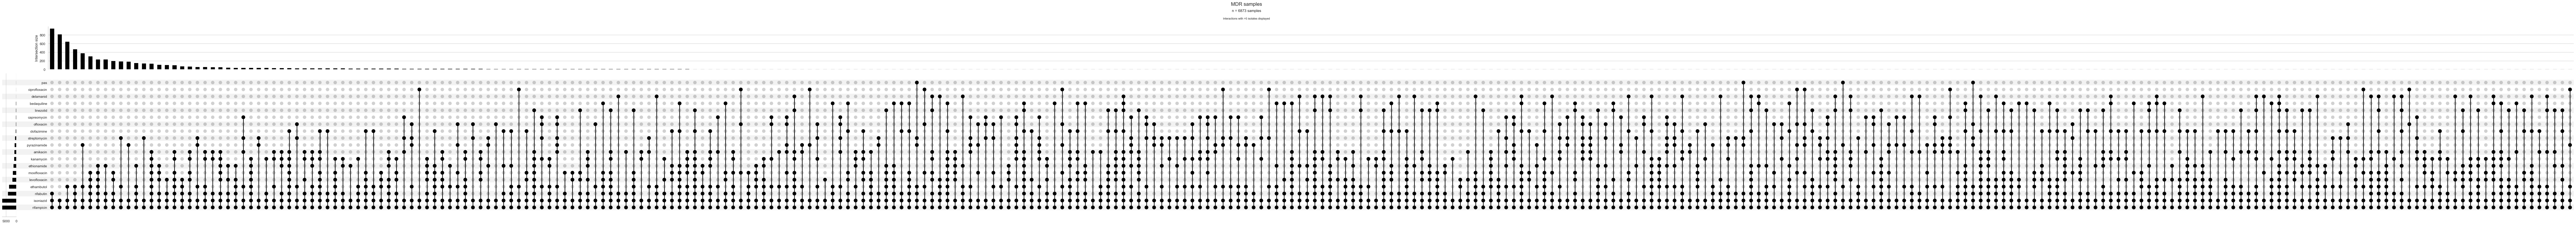

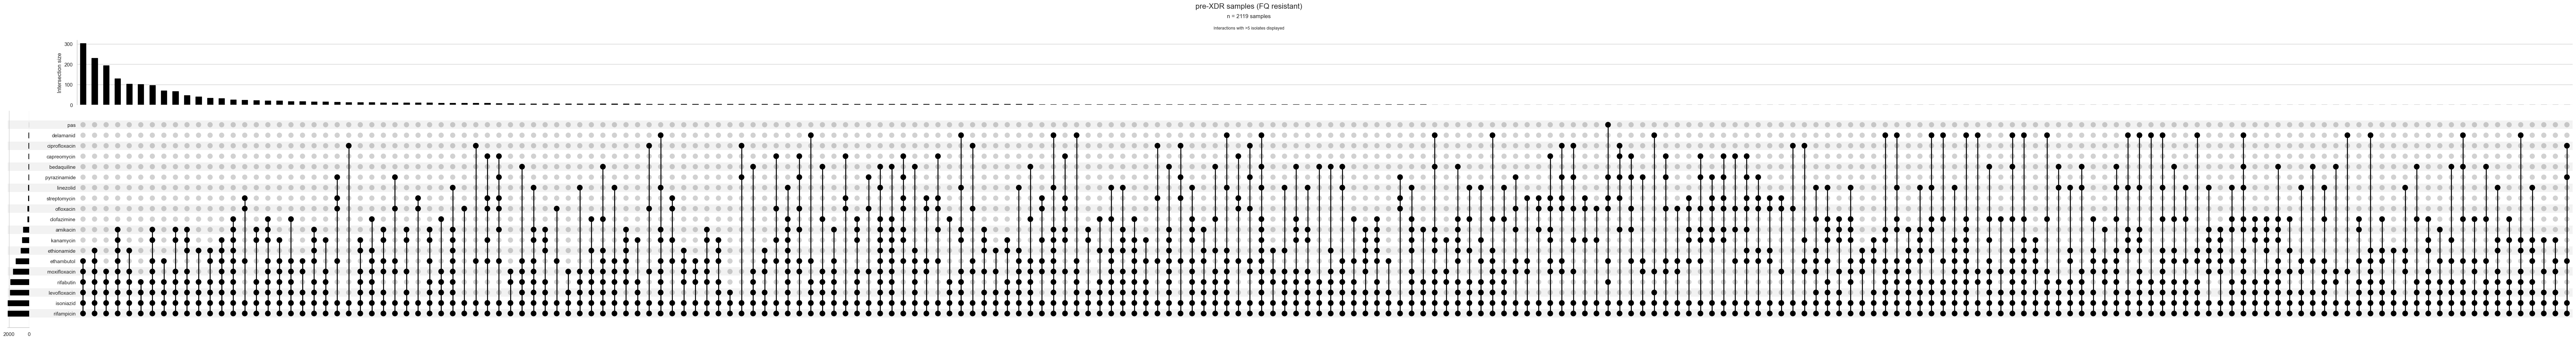

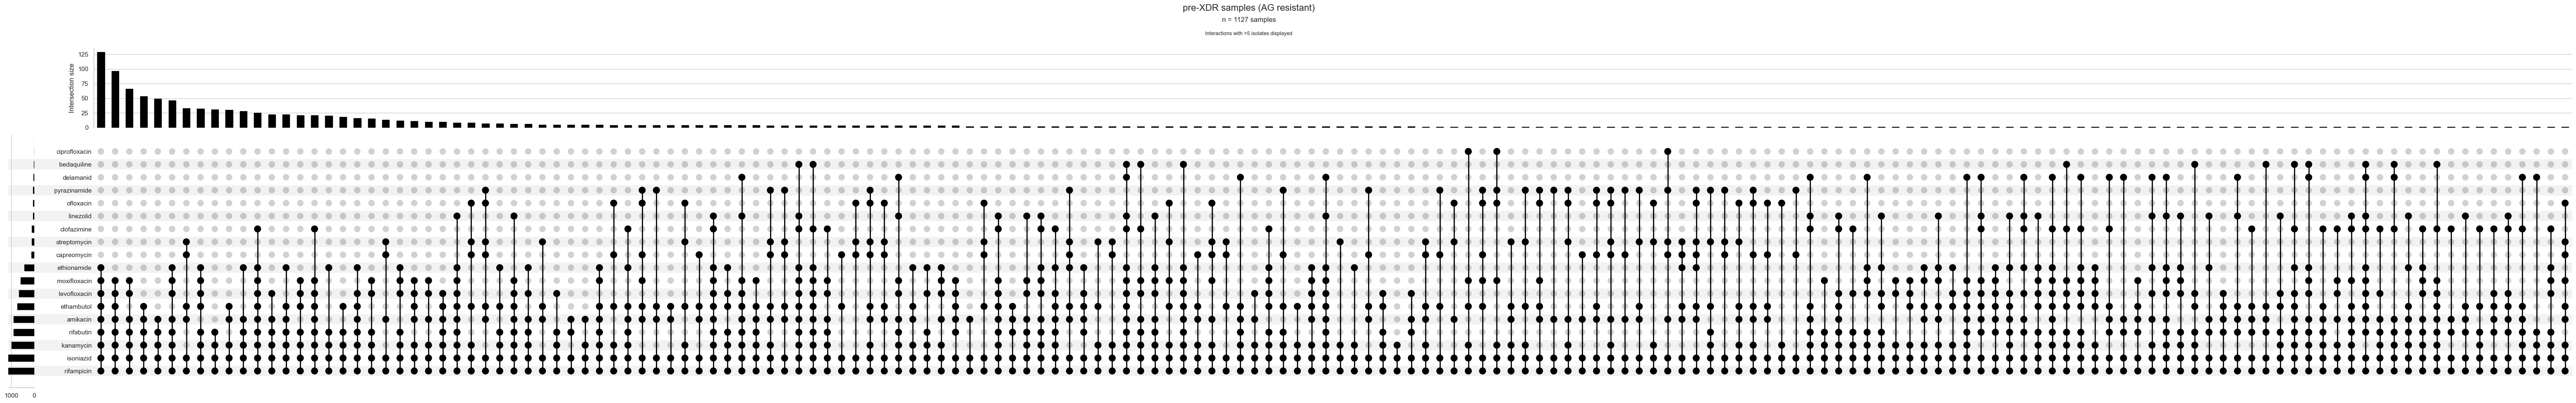

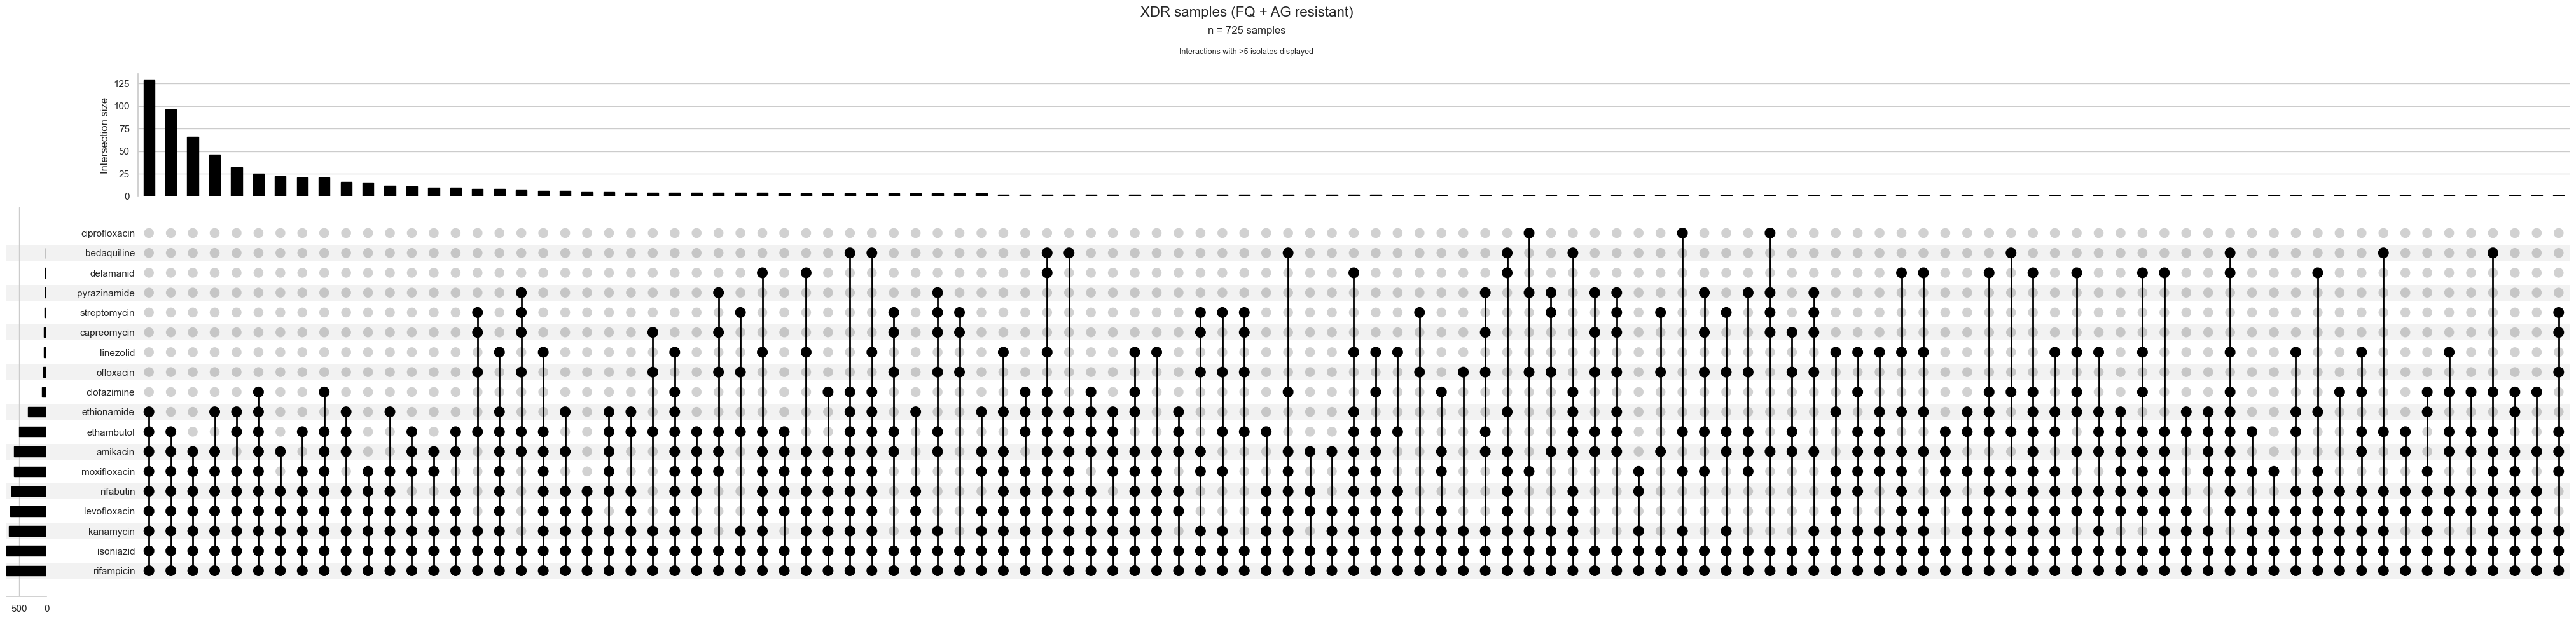

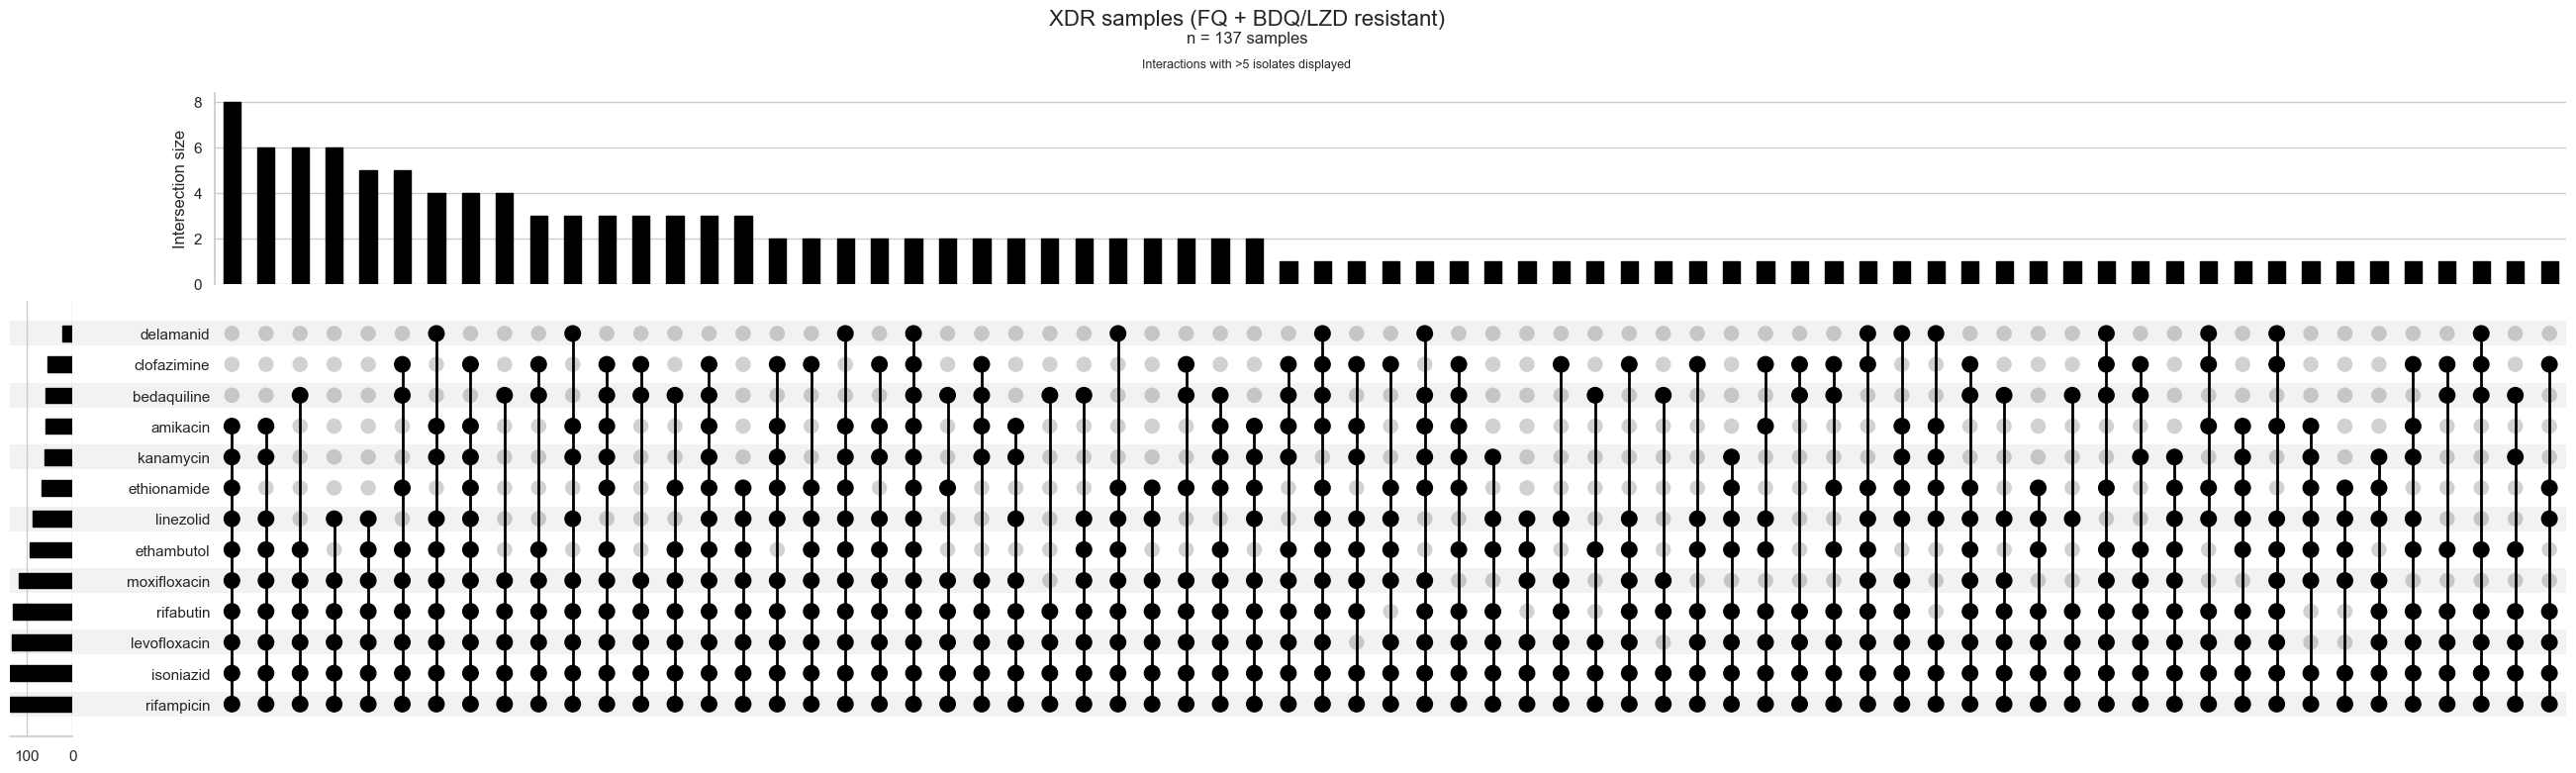

In [560]:
import warnings

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

# Helper function to create binary data for upset plots
def prepare_upset_data(data, filters, plot_order):
    # Apply the filter for the subset
    filtered_data = data.query(filters)

    # Transform relevant columns to binary (1 for 'R', 0 otherwise)
    binary_data = filtered_data.assign(
        **{col: filtered_data[col].apply(lambda x: 1 if x == "R" else 0) for col in plot_order}
    )[plot_order]

    # Number of samples
    n_samples = binary_data.shape[0]

    return binary_data, n_samples

def create_upset_plot(data, title, n_samples, file_name):
    # Ensure columns are boolean
    data_boolean = data.astype(bool)

    # Convert to UpSet-compatible format
    data_for_upset = from_indicators(indicators=data_boolean.columns, data=data_boolean)

    # Create the UpSet plot
    upset = UpSet(data_for_upset, subset_size="count", sort_by="cardinality", sort_categories_by="cardinality")
    upset.plot()

    # Add additional text
    plt.suptitle(title, fontsize=16)
    plt.figtext(0.5, 0.94, f"n = {n_samples} samples", ha="center", fontsize=12)
    plt.figtext(0.5, 0.91, "Interactions with >5 isolates displayed", ha="center", fontsize=9)

    # Save the plot
    plt.savefig(file_name, format="pdf", bbox_inches="tight")
    plt.show()

# 1. MDR = RIF + INH
mdr_data, n_samples_mdr = prepare_upset_data(
    training_data,
    "rifampicin == 'R' & isoniazid == 'R'",
    plot_order
)
create_upset_plot(mdr_data, "MDR samples", n_samples_mdr, f"./pdfs/MDR_training_upset_plot_20240117.pdf")

# 2. pre-XDR TB (FQ resistant)
preXDR_FQ_data, n_samples_preXDR_FQ = prepare_upset_data(
    training_data,
    "rifampicin == 'R' & isoniazid == 'R' & (moxifloxacin == 'R' | ofloxacin == 'R' | levofloxacin == 'R' | ciprofloxacin == 'R')",
    plot_order
)
create_upset_plot(preXDR_FQ_data, "pre-XDR samples (FQ resistant)", n_samples_preXDR_FQ, f"./pdfs/preXDR_FQ_training_upset_plot_20240117.pdf")

# 3. pre-XDR TB (AG resistant)
preXDR_AG_data, n_samples_preXDR_AG = prepare_upset_data(
    training_data,
    "rifampicin == 'R' & isoniazid == 'R' & (kanamycin == 'R' | amikacin == 'R' | capreomycin == 'R')",
    plot_order
)
create_upset_plot(preXDR_AG_data, "pre-XDR samples (AG resistant)", n_samples_preXDR_AG, f"./pdfs/preXDR_AG_training_upset_plot_20240117.pdf")

# 4. XDR TB (FQ + AG resistant)
XDR_data, n_samples_XDR = prepare_upset_data(
    training_data,
    "rifampicin == 'R' & isoniazid == 'R' & (moxifloxacin == 'R' | ofloxacin == 'R' | levofloxacin == 'R' | ciprofloxacin == 'R') & (kanamycin == 'R' | amikacin == 'R' | capreomycin == 'R')",
    plot_order
)
create_upset_plot(XDR_data, "XDR samples (FQ + AG resistant)", n_samples_XDR, f"./pdfs/XDR_FQ_AG_training_upset_plot_20240117.pdf")

# 5. XDR TB (FQ + BDQ/LZD resistant)
XDR_BL_data, n_samples_XDR_BL = prepare_upset_data(
    training_data,
    "rifampicin == 'R' & isoniazid == 'R' & (moxifloxacin == 'R' | ofloxacin == 'R' | levofloxacin == 'R' | ciprofloxacin == 'R') & (bedaquiline == 'R' | linezolid == 'R')",
    plot_order
)
create_upset_plot(XDR_BL_data, "XDR samples (FQ + BDQ/LZD resistant)", n_samples_XDR_BL, f"./pdfs/XDR_FQ_BDQ_LZD_training_upset_plot_20240117.pdf")
